# Baseline Model

A baseline CNN model with 2 convolutional layers and 3 fully-connected layers.


### 1. Data Loading and Splitting 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=b359d712a98ed531765d352afe05e442a9feee839aad9975943dff15b695b836
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valentinamanferrari","key":"6124c1d86b4b80417e8a6672051eda5e"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:03<00:00, 98.3MB/s]
100% 325M/325M [00:03<00:00, 88.7MB/s]


In [ ]:
! mkdir dataset

In [ ]:
! unzip skin-cancer-malignant-vs-benign.zip -d dataset

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/data/train/benign/420.jpg  
  inflating: dataset/data/train/benign/421.jpg  
  inflating: dataset/data/train/benign/422.jpg  
  inflating: dataset/data/train/benign/423.jpg  
  inflating: dataset/data/train/benign/424.jpg  
  inflating: dataset/data/train/benign/425.jpg  
  inflating: dataset/data/train/benign/426.jpg  
  inflating: dataset/data/train/benign/429.jpg  
  inflating: dataset/data/train/benign/43.jpg  
  inflating: dataset/data/train/benign/430.jpg  
  inflating: dataset/data/train/benign/431.jpg  
  inflating: dataset/data/train/benign/432.jpg  
  inflating: dataset/data/train/benign/434.jpg  
  inflating: dataset/data/train/benign/435.jpg  
  inflating: dataset/data/train/benign/438.jpg  
  inflating: dataset/data/train/benign/439.jpg  
  inflating: dataset/data/train/benign/440.jpg  
  inflating: dataset/data/train/benign/441.jpg  
  inflating: dataset/data/train/benign/442.jpg  
  inflating: dataset

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data Loading

train_path ='/content/dataset/train'
test_path='/content/dataset/test'

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] 
        label_class = classes[label_index] 
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes,batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    classes = ("malignant", "benign")

    ########################################################################
    # Transfrom images to tensors
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

    train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(train_dataset, classes, target_classes)
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.90) #10% for validation
    
    # split into training, validation
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers = 1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                              num_workers=1, shuffle=True)
    
    return train_loader, valid_loader, test_loader, classes

In [ ]:
train,val,test,classes = get_data_loader(target_classes=["malignant", "benign"], batch_size=1)

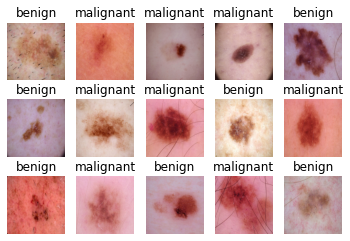

In [ ]:
# Plot some examples from training set 

k = 0
for images, labels in train:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    # Add the label as title for image
    plt.title(classes[labels[0]])
    plt.axis('off')
    plt.imshow(img)
    k += 1
    if k > 14:
        break

In [ ]:
print(len(train))
print(len(val))
print(len(test))
"""
We have opted for a 70/30 split, with approximately 10% validation and 20% testing.
"""

2373
264
660


'\nWe have opted for a 70/30 split, with approximately 10% validation and 20% testing.\n'

### 2. Baseline Model Building and Testing

In [ ]:
class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.name = "cnn"
          self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 5, padding = 1) 
          self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) 
          self.conv2 = nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = 5, padding = 1) 
          self.fc1 = nn.Linear(10*54*54, 120)
          self.fc2 = nn.Linear(120, 84) 
          self.fc3 = nn.Linear(84,2) # malignant or benign

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 10*54*54)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, batch_size=64, num_epochs=50,learning_rate=0.01):
    train_loader,val_loader,test_loader,classes = get_data_loader(target_classes=["malignant","benign"],batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(epoch, train_acc[epoch], val_acc[epoch]))
        n += 1
            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 0 - Training Accuracy: 0.6380109565950274, Validation Accuracy: 0.6590909090909091
Epoch 1 - Training Accuracy: 0.7640117994100295, Validation Accuracy: 0.7840909090909091
Epoch 2 - Training Accuracy: 0.7168141592920354, Validation Accuracy: 0.75
Epoch 3 - Training Accuracy: 0.78803202697008, Validation Accuracy: 0.7954545454545454
Epoch 4 - Training Accuracy: 0.8057311420143278, Validation Accuracy: 0.8068181818181818
Epoch 5 - Training Accuracy: 0.798567214496418, Validation Accuracy: 0.8295454545454546
Epoch 6 - Training Accuracy: 0.8074167720185419, Validation Accuracy: 0.821969696969697
Epoch 7 - Training Accuracy: 0.8019384745048462, Validation Accuracy: 0.8484848484848485
Epoch 8 - Training Accuracy: 0.8019384745048462, Validation Accuracy: 0.8409090909090909
Epoch 9 - Training Accuracy: 0.8735777496839444, Validation Accuracy: 0.8598484848484849
Epoch 10 - Training Accuracy: 0.8929624947324062, Validation Accuracy: 0.848484848484848

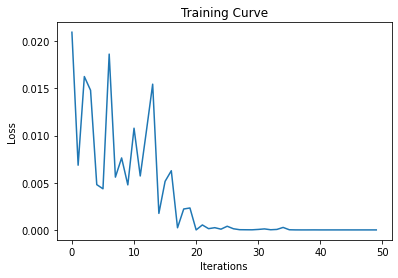

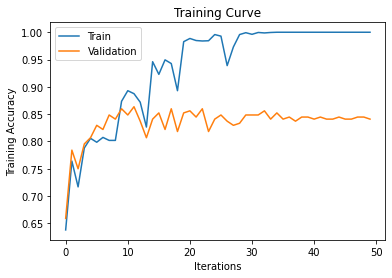

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8409090909090909


In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model with batch size 32 lr 0.001
train(model,batch_size=32, num_epochs=50,learning_rate=0.001)

In [ ]:
train_loader,val_loader,test_loader,classes = get_data_loader(["malignant","benign"],batch_size=32)
test_acc = get_accuracy(model, test_loader)
print("Test Accuracy :", test_acc)

Test Accuracy : 0.8424242424242424


### 3. Testing on Unseen Data

In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder('/content/test', transform=transform)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                              num_workers = 1)

In [ ]:
def get_unseen_accuracy(model, data):
    predict = []
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        predict.append(classes[pred[0].item()])
    return predict

In [ ]:
pred = get_unseen_accuracy(model,data_loader)

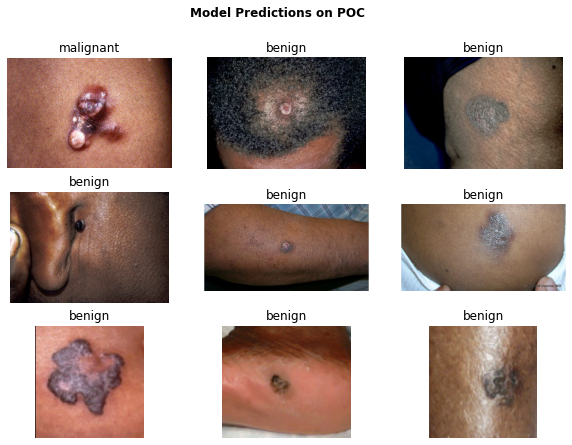

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Model Predictions on POC', fontsize=12, fontweight='bold')
  
# setting values to rows and column variables
rows = 3
columns = 3

img1 = plt.imread('/content/test/images/1-s2.0-S0190962205027301-gr19.jpg')
img2 = plt.imread('/content/test/images/CSCC-on-the-scalp-of-a-Black-man-340x240.jpeg')
img3 = plt.imread('/content/test/images/Pigmented-BCC-340x240.jpeg')
img4 = plt.imread('/content/test/images/Pigmented-BCC-behind-the-ear-340x240.jpeg')
img5 = plt.imread('/content/test/images/cq5dam.thumbnail.600.600 (1).jpeg')
img6 = plt.imread('/content/test/images/cq5dam.thumbnail.600.600.jpeg')
img7 = plt.imread('/content/test/images/skin-cancer-people-of-color-image-collage-2.jpg')
img8 = plt.imread('/content/test/images/skin-cancer-people-of-color-image-collage-23.jpg')
img9 = plt.imread('/content/test/images/skin-cancer-people-of-color-image-collage-24.jpg')

fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1)
plt.axis('off')
plt.title(pred[0])

fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(img2)
plt.axis('off')
plt.title(pred[1])

fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img3)
plt.axis('off')
plt.title(pred[2])

fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(img4)
plt.axis('off')
plt.title(pred[3])

fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(img5)
plt.axis('off')
plt.title(pred[4])

fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(img6)
plt.axis('off')
plt.title(pred[5])

fig.add_subplot(rows, columns, 7)

# showing image
plt.imshow(img7)
plt.axis('off')
plt.title(pred[6])

fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(img8)
plt.axis('off')
plt.title(pred[7])

fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(img9)
plt.axis('off')
plt.title(pred[8])

plt.show()

In [ ]:
"""
The baseline model has an accuracy of only 11.11% on darker skin tones, 
as all samples were malignant skin lesions. This can be seen in the figure above.
Thus, our baseline model performs poorly on unseen samples taken from darker skin tones
that were not a part of the original dataset.
"""